In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from scipy.interpolate import RectBivariateSpline
path = '../PostBornEma/'
sys.path.append("../scripts/") 
from lab import *

### 1) Terms that also appear in Limber approximation

#### Collecting all contributions from Eq.s 4.2-4.5 that are also non-zero in Limber

Term 1:
$- \int_{\vec{l}} [\vec{L}\cdot \vec{l}] [\vec{l}\cdot (\vec{L}-\vec{l})]^2 \int \mathrm{d}\chi \int \mathrm{d}\chi' W(\chi,\chi_{CMB}) W^h(\chi') C_l^{\delta\psi}(\chi',\chi) C_{|\vec{L}-\vec{l}|}^{\phi\phi}(\chi',\chi) = - \int_{\vec{l}} [\vec{L}\cdot \vec{l}] [\vec{l}\cdot (\vec{L}-\vec{l})]^2 M^{A}(l,|\vec{L}-\vec{l}|)$
after  transform $\vec{l} \rightarrow \vec{l}+\vec{L}$

$\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2 M^{A}( |\vec{L}+\vec{l}|,l)$

Term 2: 
$ L^2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 \int \mathrm{d}\chi \int \mathrm{d}\chi' W(\chi,\chi_{CMB}) W^h(\chi') C_L^{\delta\psi}(\chi',\chi) [\frac{1}{2}C_{l}^{\phi\phi}(\chi')+\frac{1}{2}C_{l}^{\phi\phi}(\chi)]$
$ = L^2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 \tilde{M}^{A}(L,l)$

Comparison with Limber results suggest that we are missing a minus sign in Term 2. Will be coding with this Minus sign

Adding Term 1 and 2 with trick from Krause & Hirata:
$\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2 [M^{A}( |\vec{L}+\vec{l}|,l)-\tilde{M}^{A}(L,l)] +  \left[\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2-L^2[\vec{L}\cdot \vec{l}]^2\right] \tilde{M}^{A}(L,l)$


In [2]:
# naming corresponds to order of axes
chi1s, chi2s, clphiphirt = np.load('../G_matrices/clphiphi_rt.npy')
chi1s_, chi2s_, clphiphir_over_t = np.load('../G_matrices/clphiphi_r_over_t.npy')
clphiphirt = np.swapaxes(clphiphirt,1,2)
clphiphir_over_t = np.swapaxes(clphiphir_over_t,1,2)

In [3]:
chi1s.shape

(50, 2)

In [4]:
r2d, t2d = np.meshgrid(t_,t_)
#checking if axes of clphiphi are ordered correctly
print(np.swapaxes(chi2s,0,1)[0],(r2d*t2d*chi_cmb)[0])
print(np.swapaxes(chi2s_,0,1)[0],(r2d/t2d*chi_cmb)[0])

(array([  1.92887131e-04,   1.01610380e-03,   2.49628944e-03,
         4.63232690e-03,   7.42216945e-03,   1.08631008e-02,
         1.49517621e-02,   1.96841596e-02,   2.50556701e-02,
         3.10610455e-02,   3.76944181e-02,   4.49493067e-02,
         5.28186228e-02,   6.12946773e-02,   7.03691885e-02,
         8.00332899e-02,   9.02775388e-02,   1.01091926e-01,
         1.12465884e-01,   1.24388301e-01,   1.36847526e-01,
         1.49831387e-01,   1.63327196e-01,   1.77321768e-01,
         1.91801428e-01,   2.06752029e-01,   2.22158963e-01,
         2.38007175e-01,   2.54281181e-01,   2.70965080e-01,
         2.88042569e-01,   3.05496964e-01,   3.23311208e-01,
         3.41467898e-01,   3.59949291e-01,   3.78737330e-01,
         3.97813657e-01,   4.17159633e-01,   4.36756356e-01,
         4.56584678e-01,   4.76625225e-01,   4.96858415e-01,
         5.17264480e-01,   5.37823480e-01,   5.58515328e-01,
         5.79319806e-01,   6.00216586e-01,   6.21185250e-01,
         6.42205311e-01

### Coding the new equation for Term 1:
$\frac{\mathcal A}{2 \pi^2} \sum_n \int dr \chi_{cmb}^{-\nu} r^{-\nu-1} W(r \chi_{cmb},\chi_{cmb}) [1+z(r \chi_{cmb})] D(r \chi_{cmb})\int dt I^{(2)}(\nu_n, t)[ D(tr  \chi_{cmb})W_h(tr  \chi_{cmb}) C_{l1}^{\phi\phi}(tr  \chi_{cmb},r \chi_{cmb}+ t^\nu D(r/t  \chi_{cmb})W_h(r/t  \chi_{cmb}) C_{l1}^{\phi\phi}(r/t  \chi_{cmb},r \chi_{cmb}))]$

In [6]:
#getting MA
bin_num = 'all'
_, MA = np.load('../M_matrices/MA_bin_%s.npy'%str(bin_num))
# 
# def lensing_kernel(xi, xmax):
#     return (xmax - xi)/(xmax*xi) * (xmax > xi)

# kernel1 = lensing_kernel
# kernel2 = lsst_kernel_cb

# r2d, t2d = np.meshgrid(t_,t_)
# w11, w12 = np.meshgrid(w1,w1)
# #nu axis
# r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
# w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

# clphiphirt_ = np.expand_dims(clphiphirt,-1)
# clphiphir_over_t_ = np.expand_dims(clphiphir_over_t,-1)

# result = np.zeros((len(ell_),len(ell_)))

# chimax  = chi_cmb

# n = 2

# begin=time.time()
# for nn in range(len(ell_)):
#     if nn%10==0:
#         print(nn)
#     chi1fac0 = (kernel1(r2d*chimax,chimax)*D_chi(r2d*chimax)*(1.+z_chi(r2d*chimax)))
#     chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

#     chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax)*clphiphirt_[nn])
#     chi2fac01 = (kernel2(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax)*clphiphir_over_t_[nn])
#     chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
#     chi2fac0  = chi2fac00 + chi2fac01

#     chifacs   = w11*w12*chi1fac0* chi2fac0

#     lmax = ell_.size
#     for ii  in range(ell_.size):        
#         result[nn][ii] = np.sum(chifacs*I2_ltrc[ii])
        
# print(time.time()-begin)

# MA = chimax * result*1./np.pi**2/2.*prefac/4.
#np.save('../M_matrices/MA_bin_%s'%str(bin_num),[np.meshgrid(ell_),MA.T])


In [7]:
MA_spline = RectBivariateSpline(ell_,ell_,MA)


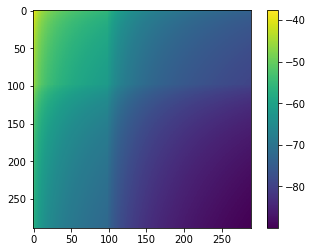

In [8]:
plt.imshow(np.log(MA))
plt.colorbar()

120.0


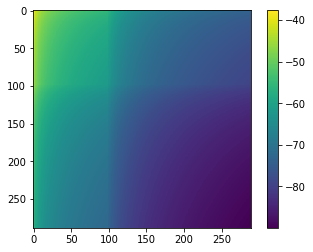

In [9]:
print(ell_[100])
#chirags result
cl22a = np.load('../output/cl22a-v2.npy')
plt.imshow(np.log(cl22a))
plt.colorbar()

In [10]:
#agreement with chirags result after changing ell-axes
MA/cl22a

array([[ 1.00000921,  1.00000512,  1.00000364, ...,  0.99991438,
         0.99991419,  0.99991401],
       [ 1.00001075,  1.00000596,  1.00000422, ...,  0.9999418 ,
         0.99994166,  0.99994153],
       [ 1.00001202,  1.00000667,  1.00000469, ...,  0.99995808,
         0.99995798,  0.99995787],
       ..., 
       [ 1.00000273,  1.00000201,  1.00000164, ...,  1.        ,
         1.        ,  1.        ],
       [ 1.00000272,  1.000002  ,  1.00000164, ...,  1.        ,
         1.        ,  1.        ],
       [ 1.0000027 ,  1.00000199,  1.00000163, ...,  1.        ,
         1.        ,  1.        ]])

### clphiphi diag for term 2

In [11]:
clphiphi   = np.load('../G_matrices/clphiphi_parallel.npy')

cl_phiphi_diag= np.zeros((len(ell_),len(t_)))
for ii in range(len(t_)):
    cl_phiphi_diag[:,ii]=clphiphi[:,ii,ii]

clphiphi_diag=[]
from scipy.interpolate import interp1d
for ii in range(len(ell_)):
    clphiphi_diag+=[interp1d(chi_cmb*t_,cl_phiphi_diag[ii])]

In [12]:
#getting tilde MA

#transpose of code
_, tildeMA1 = np.load('../M_matrices/tildeMA1_bin_%s.npy'%str(bin_num))

# bin_num = 'all'
# def lensing_kernel(xi, xmax):
#     return (xmax - xi)/(xmax*xi) * (xmax > xi)*(1.+z_chi(xi))

# kernel1 = lensing_kernel
# kernel2 = lsst_kernel_cb

# r2d, t2d = np.meshgrid(t_,t_)
# w11, w12 = np.meshgrid(w1,w1)
# #nu axis
# r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
# w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


# result = np.zeros((len(ell_),len(ell_)))

# chimax  = chi_cmb

# n = 2

# begin=time.time()
# for nn in range(len(ell_)):
#     if nn%10==0:
#         print(nn)
    
#     chi1fac0 = (kernel2(r2d*chimax)*D_chi(r2d*chimax)*clphiphi_diag[nn](r2d*chimax))
#     chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

#     chi2fac00 = (kernel1(t2d*r2d*chimax,chimax)*D_chi(r2d*t2d*chimax))
#     chi2fac01 = (kernel1(1./t2d*r2d*chimax,chimax)*D_chi(r2d/t2d*chimax))
#     chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
#     chi2fac0  = chi2fac00 + chi2fac01

#     chifacs   = w11*w12*chi1fac0* chi2fac0

#     lmax = ell_.size
#     for ii  in range(ell_.size):        
#         result[nn][ii] = np.sum(chifacs*I2_ltrc[ii])
        
# print(time.time()-begin)

# tildeMA1 = chimax * result*1./np.pi**2/2.*prefac/4./2.

#np.save('../M_matrices/tildeMA1_bin_%s'%str(bin_num),[np.meshgrid(ell_),tildeMA1.T])

In [13]:
tildeMA_spline1 = RectBivariateSpline(ell_,ell_,tildeMA1)


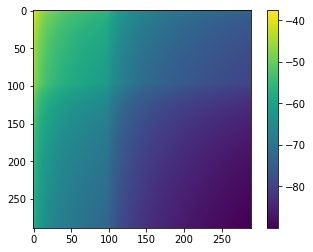

In [14]:
#chirags result
cl13a = np.load('../output/cl13a.npy')
plt.imshow(np.log(cl13a))
plt.colorbar()

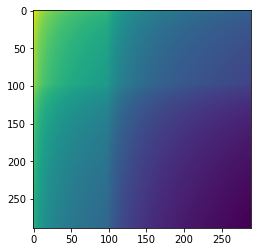

In [15]:
plt.imshow(np.log(tildeMA1))

In [16]:
tildeMA1/cl13a

array([[ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5],
       [ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5],
       [ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5],
       ..., 
       [ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5],
       [ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5],
       [ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5]])

In [17]:
#getting tilde MA2
_, tildeMA2 = np.load('../M_matrices/tildeMA2_bin_%s.npy'%str(bin_num))

# bin_num = 'all'
# def lensing_kernel(xi, xmax):
#     return (xmax - xi)/(xmax*xi) * (xmax > xi)*(1.+z_chi(xi))

# kernel1 = lensing_kernel
# kernel2 = lsst_kernel_cb

# r2d, t2d = np.meshgrid(t_,t_)
# w11, w12 = np.meshgrid(w1,w1)
# #nu axis
# r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
# w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


# result = np.zeros((len(ell_),len(ell_)))

# chimax  = chi_cmb

# n = 2

# begin=time.time()
# for nn in range(len(ell_)):
#     if nn%10==0:
#         print(nn)
    
#     chi1fac0 = (kernel1(r2d*chimax,chimax)*D_chi(r2d*chimax)*clphiphi_diag[nn](r2d*chimax))
#     chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

#     chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
#     chi2fac01 = (kernel2(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax))
#     chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
#     chi2fac0  = chi2fac00 + chi2fac01

#     chifacs   = w11*w12*chi1fac0* chi2fac0

#     lmax = ell_.size
#     for ii  in range(ell_.size):        
#         result[nn][ii] = np.sum(chifacs*I2_ltrc[ii])
        
# print(time.time()-begin)

# tildeMA2 = chimax * result*1./np.pi**2/2.*prefac/4./2.

# np.save('../M_matrices/tildeMA2_bin_%s'%str(bin_num),[np.meshgrid(ell_),tildeMA2.T])

In [18]:
tildeMA2_spline = RectBivariateSpline(ell_,ell_,tildeMA2)


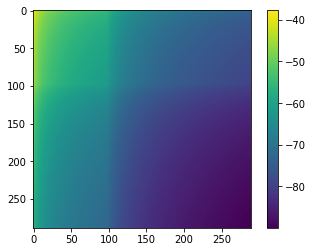

In [19]:
#chirags result
cl31aA = np.load('../output/cl31aA.npy')
plt.imshow(np.log(cl31aA))
plt.colorbar()

In [20]:
cl31aA/tildeMA2

array([[ 2.,  2.,  2., ...,  2.,  2.,  2.],
       [ 2.,  2.,  2., ...,  2.,  2.,  2.],
       [ 2.,  2.,  2., ...,  2.,  2.,  2.],
       ..., 
       [ 2.,  2.,  2., ...,  2.,  2.,  2.],
       [ 2.,  2.,  2., ...,  2.,  2.,  2.],
       [ 2.,  2.,  2., ...,  2.,  2.,  2.]])

In [21]:
tildeMA=tildeMA1+tildeMA2
np.save('../M_matrices/tildeMA_bin_%s'%str(bin_num),[np.meshgrid(ell_),tildeMA])
tildeMA_spline = RectBivariateSpline(ell_,ell_,tildeMA)

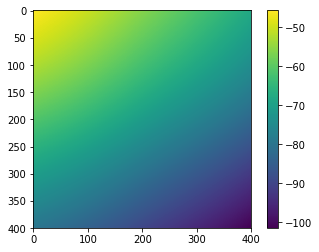

In [76]:
L, M = np.load('../output/MLimberSpline_bin_all.npy')
L1, L2 = L

plt.imshow(np.log(M/L1**2/L2**4))
plt.colorbar()

## Now that we have $M^A$ s: coding this equations
$\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2 [M^{A}( |\vec{L}+\vec{l}|,l)-\tilde{M}^{A}(L,l)] +  \left[\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2-L^2[\vec{L}\cdot \vec{l}]^2\right] \tilde{M}^{A}(L,l)$

In [23]:
def get_regularized_sum_of_terms(L,L1,phi,M1,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2+2.*LL1/LL*nu)
            integrand = LL1*(LL**2+LL*LL1*nu)*(LL1**2+LL*LL1*nu)**2*(M1(L_,LL1,grid=False)-M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res


#numerical angular integration
def get_second_sum_of_terms(L,L1,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand =  LL1*((LL**2+LL*LL1*nu)*(LL1**2+LL*LL1*nu)**2-LL**2*(LL*LL1*nu)**2)*(M(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res

In [24]:
# use same sampling as in Limber case
L     = np.logspace(1,4,400)

# sampling for integrations
phi = np.linspace(0.,2.*np.pi,1000,endpoint=True)
L1  = np.logspace(-1,5,400)

In [72]:
MA_spline = RectBivariateSpline(ell_,ell_,MA)
tildeMA_spline  = RectBivariateSpline(ell_,ell_,tildeMA.T)

begin = time.time()
all_bins = get_regularized_sum_of_terms(L,L1,phi,MA_spline,tildeMA_spline,method='trapz')+get_second_sum_of_terms(L,L1,tildeMA_spline,method='trapz')
print(time.time()-begin)

75.5640618801


In [38]:
ell_ext = np.append(ell_,np.linspace(ell_[-1]+1,4000,10))
tildeMA_cut = np.zeros((len(ell_ext),len(ell_ext)))



In [41]:
ind = np.where(ell_<1000)
for ii in ind[0]:
    for jj in ind[0]:
        tildeMA_cut[ii][jj]=tildeMA[ii][jj]

/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


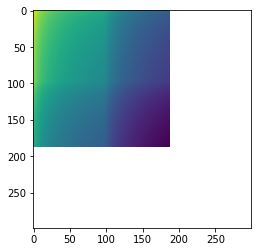

In [45]:
plt.imshow(np.log(tildeMA_cut))

In [46]:
tildeMA_cut_spline = RectBivariateSpline(ell_ext,ell_ext,tildeMA_cut)

In [47]:
L, corrs = np.load('../output/LimberPostBornResultsLSST.npy')

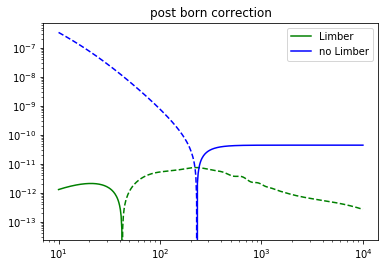

In [75]:
plt.figure()
plt.title('post born correction')
plt.loglog(L,corrs[-1],label='Limber',color='g')
plt.loglog(L,-corrs[-1],color='g',ls='--')
plt.loglog(L,all_bins/L**2,label='no Limber',color='b')
plt.loglog(L,-all_bins/L**2,color='b',ls='--')
plt.legend()

### Compare only the 31 term, which can be done analytically
$L^2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 \tilde{M}^{A}(L,l)$

In [49]:
L,Cl31s = np.load('../output/LimberPostBornCl31_kappa-gal.npy')

L,Cl31_cut = np.load('../output/LimberPostBornCl31_kappa-gal_all_cut.npy')

In [50]:
def get_31_term(M,L,L1):
    return L**4/4./np.pi*np.trapz(M(L,L1)*L1**3,L1)

In [51]:
myCl31 = get_31_term(tildeMA_spline,L,L1)
myCl31cut = get_31_term(tildeMA_cut_spline,L,L1)

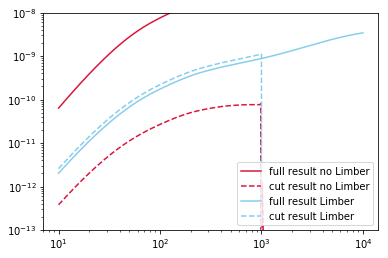

In [60]:
plt.loglog(L,myCl31,label='full result no Limber',color='crimson')
plt.loglog(L,myCl31cut,label='cut result no Limber', ls = '--',color='crimson')
plt.loglog(L,-Cl31s[-1],label = 'full result Limber',color='skyblue' )
plt.loglog(L,-Cl31_cut,label = 'cut result Limber', ls = '--',color='skyblue' )
plt.ylim(1e-13,1e-8)
plt.legend()

/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in divide
  """Entry point for launching an IPython kernel.


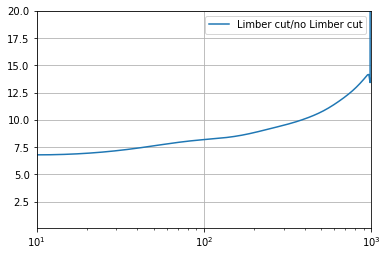

In [61]:
plt.semilogx(L,-Cl31_cut/myCl31cut, label='Limber cut/no Limber cut')
plt.grid()
plt.ylim(0.1,20)
plt.xlim(10,1000)
plt.legend()

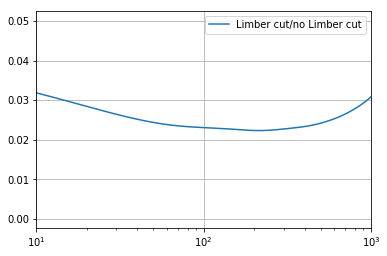

In [66]:
plt.semilogx(L,-Cl31s[-1]/myCl31, label='Limber cut/no Limber cut')
plt.grid()
#plt.ylim(0.1,20)
plt.xlim(10,1000)
plt.legend()

In [ ]:
MA(2000,2000),MA(3000,3000)

In [ ]:
tildeMA2(1002,1002)